# Hysteresis Loops Fitting

In [1]:
import sys
sys.path.append('../../')
sys.path.append('../../src')

In [2]:
%load_ext autoreload
%autoreload 2

import h5py
import pyUSID as usid

from src.m3_learning.be.processing import fit_loop_function, loop_lsqf
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.viz.layout import subfigures

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model
from m3_learning.nn.Fitter1D.Fitter1D import Multiscale1DFitter, Model
# from m3_learning.nn.Fitter1D.Fitter1D_new import Multiscale1DFitter, Model
from m3_learning.be.filters import clean_interpolate

printing = printer(basepath = './Figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline

2024-08-13 18:52:06.925167: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 18:52:06.925200: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 18:52:06.926300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 18:52:06.932046: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 18:52:07.569963: W tensorflow/compiler/tf2

printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [3]:
from BGlib import be as belib


In [4]:
import pkg_resources

# Check the version of BGlib
bg_version = pkg_resources.get_distribution("BGlib").version
bg_version

/tmp/ipykernel_74589/616780478.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


'0.0.6'

In [5]:
pkg_resources.get_distribution("numpy").version

'1.26.4'

In [6]:
import sys
sys.version

'3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]'

## Loads data

In [7]:
# Ensure python 3 compatibility
from __future__ import division, print_function, absolute_import

# Import necessary libraries:
# General utilities:
import os

# Computation:
import numpy as np
import h5py

# Visualization:
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# The engineering components supporting BGlib:
import sidpy
import pyUSID as usid
# Finally, BGlib itself
from BGlib import be as belib

# Make Notebook take up most of page width
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# For the notebook to work you must have m3_learning installed
# pip install m3_learning
%load_ext autoreload
%autoreload 2

import numpy as np

from m3_learning.nn.random import random_seed
from m3_learning.viz.style import set_style
from m3_learning.util.file_IO import download_and_unzip
from m3_learning.viz.printing import printer
from m3_learning.be.viz import Viz
from m3_learning.be.dataset import BE_Dataset
from IPython.display import Video


# from m3_learning.be.dataset import BE_Dataset
printing = printer(basepath = './Figures/')

set_style("printing")
random_seed(seed=42)

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


In [8]:
max_mem = 1024*8  # Maximum memory to use, in Mbs. Default = 1024
# Number of logical cores to use in fitting.  None uses all but 2 available cores.
max_cores = None
results_to_new_file = False

In [8]:
# Download the data file from Zenodo
url = 'https://zenodo.org/record/7774788/files/PZT_2080_raw_data.h5?download=1'

# Specify the filename and the path to save the file
filename = '/data_raw_7_25.h5'
save_path = './Data'

# download the file
download_and_unzip(filename, url, save_path)

h5_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/hysteresis copy.h5"

h5_path = save_path + filename

Using files already downloaded


In [9]:
# h5_path = "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Data/data_raw_manual.h5"

h5_path = save_path + filename

folder_path, h5_raw_file_name = os.path.split(h5_path)
h5_file = h5py.File(h5_path, 'r+')
print('Working on:\n' + h5_path)

h5_main = usid.hdf_utils.find_dataset(h5_file, 'Raw_Data')[0]

# h5_main

Working on:
./Data/data_raw_7_25.h5


In [10]:
print('Datasets and datagroups within the file:\n------------------------------------')
sidpy.hdf.hdf_utils.print_tree(h5_file)

print('\nThe main dataset:\n------------------------------------')
print(h5_main)

print('\nMetadata or attributes in the measurement datagroup\n------------------------------------')
for key, val in sidpy.hdf.hdf_utils.get_attributes(h5_main.parent.parent).items():
    print('{} : {}'.format(key, val))

Datasets and datagroups within the file:
------------------------------------
/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectr

In [11]:
# instantiate the dataset object
dataset = BE_Dataset(h5_path, SHO_fit_func_LSQF=SHO_fit_func_nn)


No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values


In [12]:
# print the contents of the file
dataset.print_be_tree()

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Bin_FFT
    ├ Bin_Frequencies
    ├ Bin_Indices
    ├ Bin_Step
    ├ Bin_Wfm_Type
    ├ Excitation_Waveform
    ├ Noise_Floor
    ├ Noisy_Data_1
    ├ Noisy_Data_2
    ├ Noisy_Data_3
    ├ Noisy_Data_4
    ├ Noisy_Data_5
    ├ Noisy_Data_6
    ├ Noisy_Data_7
    ├ Noisy_Data_8
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spatially_Averaged_Plot_Group_000
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spatially_Averaged_Plot_Group_001
      ---------------------------------
      ├ Bin_Frequencies
      ├ Max_Response
      ├ Mean_Spectrogram
      ├ Min_Response
      ├ Spectroscopic_Parameter
      ├ Step_Averaged_Response
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values
    ├ UDVS
    ├ UDVS_Indices
  ├ Raw_Data-SHO_Fit_000
    ----

In [13]:
h5_loop_fit, h5_loop_group = dataset.LSQF_Loop_Fit(force=False)

Consider calling test() to check results before calling compute() which computes on the entire dataset and writes results to the HDF5 file

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (8 members)>]

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (8 members)>]
Returned previously computed results at /Measurement_000/Raw_Data-SHO_Fit_000

Note: SHO_Fit has already been performed with the same parameters before. These results will be returned by compute() by default. Set override to True to force fresh computation

[<HDF5 group "/Measurement_000/Raw_Data-SHO_Fit_000" (8 members)>]
Returned previously computed results at /M

/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Guess_Loop_Parameters already exists in group: /Measurement_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))
/home/ferroelectric/anaconda3/envs/paper/lib/python3.11/site-packages/pyUSID/io/hdf_utils/simple.py:888: UserWarning: A dataset named: Fit_Loop_Parameters already exists in group: /Measurement_000/Raw_Data-SHO_Fit_000/Fit-Loop_Fit_000
  warn('A dataset named: {} already exists in group: {}'.format(dset_name, h5_group.name))


In [14]:
data_path = save_path + '/' + filename

dataset = BE_Dataset(data_path, SHO_fit_func_LSQF=SHO_fit_func_nn)

# instantiate the visualization object
image_scalebar = [2000, 500, "nm", "br"]


BE_viz = Viz(dataset, printing, verbose=True, 
             SHO_ranges = [(0,1.5e-4), (1.31e6, 1.33e6), (-300, 300), (-np.pi, np.pi)], 
             image_scalebar = image_scalebar)

No spectroscopic datasets found as attributes of /Measurement_000/Channel_000/Position_Indices
No position datasets found as attributes of /Measurement_000/Raw_Data-SHO_Fit_000/Spectroscopic_Values
./Figures/hysteresis_comparison.png
./Figures/hysteresis_comparison.svg


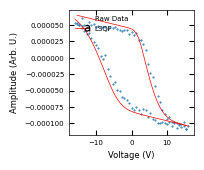

In [46]:
BE_viz.hysteresis_comparison(data = ['LSQF'])

## Neural Network Fits

In [36]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

KeyError: 'Unable to synchronously open object (component not found)'

In [31]:
from m3_learning.be.loop_fitter import loop_fitting_function_torch
from m3_learning.optimizers.TrustRegion import TRCG
import torch.optim as optim


data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
# V = np.swapaxes(np.atleast_2d(dataset.get_voltage), 0, 1).astype(np.float64)


model_ = Multiscale1DFitter(loop_fitting_function_torch, # function 
                            voltage[:,0].squeeze(), # x data
#                             V.squeeze(),
                            1, # input channels
                            9, # output parameters
                            dataset.loop_param_scaler,
                            loops_scaler=dataset.hysteresis_scaler)

# instantiate the model
model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")

from sklearn.model_selection import train_test_split


X_train, X_test = train_test_split(data.reshape(-1,96), test_size=0.2, random_state=42, shuffle=True)

X_train = np.atleast_3d(X_train)

optimizer = {
    "name": "TRCG", 
    "optimizer": TRCG,
    "closure_size": 1,
    "cgopttol": 1e-3,
    "c0tr": 0.2,
    "c1tr": 0.25,
    "c2tr": 0.75,
    "t1tr": 0.75,
    "t2tr": 2.0,
    "radius_max": 5.0,  
    "radius_initial": 1.0,
    "radius" : 1.0,
    "device": "cuda",
    "ADAM_epochs": 500}


train = True

if train:
    # fits the model
    model.fit(
        X_train,
        1024,
        optimizer=optimizer,
        epochs = 600,
    )
else:
    model.load(
        "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Rapid_Fitting/Trained Models/SHO Fitter/SHO_Fitter_original_data_model_epoch_5_train_loss_0.0449272525189978.pth"
    )

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_158961/3599253829.py", line 6, in <module>
    data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
  File "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/dataset.py", line 50, in wrapper
    out = func(*args, **kwargs)
  File "/home/ferroelectric/Documents/m3_learning/m3_learning/papers/2023_Rapid_Fitting/../../src/m3_learning/be/dataset.py", line 1874, in get_hysteresis
    if output_shape is not None:
  File "h5py/_objects.pyx", line 54, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 55, in h5py._objects.with_phil.wrapper
  File "/home/ferroelectric/micromamba/envs/paper/lib/python3.10/site-packages/h5py/_hl/group.py", line 357, in __ge

In [32]:
import torch
X_train = torch.atleast_3d(torch.tensor(X_train))


train_pred_recon, train_pred_params_scaled, train_pred_params = model.predict(
    X_train,
    1024,
    translate_params=False,
    is_SHO=False
)

NameError: name 'X_train' is not defined

In [ ]:
train_pred_recon.shape
train_pred_params_scaled.shape
train_pred_params.shape

In [ ]:
X_train[1000].shape

In [ ]:
voltage.shape

In [ ]:
i = np.random.randint(0, X_train.shape[0])

import matplotlib.pyplot as plt
plt.plot(voltage, X_train[i])
plt.plot(voltage, np.atleast_2d(train_pred_recon[i]))

### Evaluate the Neural Network Results

In [ ]:
d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_train,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Train",
)

In [ ]:
X_test = torch.atleast_3d(torch.tensor(X_test))

d1, d2, index1, mse1 = BE_viz.bmw_nn(
    X_test,
    prediction=model,
    returns=True,
    fit_type="hysteresis",
    filename="Figure_X_NN_validation_Test",
)

### Calculate the MSE

In [ ]:
data_ = (torch.atleast_3d(torch.tensor(data.reshape(-1, 96))), X_test, X_train)
labels = ["Full Data", "Test Data", "Train Data"]

model.print_mse(data_, labels, is_SHO=False)

## Comparison of LSQF and Neural Network Fits

3 graphs, best, median, worst

histograms of parameters.


In [ ]:
n = 1

data = ("LSQF", "NN")
# names = ["LSQF", "NN"]

BE_viz.hysteresis_comparison(
    data,
    model=model,
    filename="Figure_XX_LSQF_NN_bmw_comparison",
)

### Statistics of the Results for Training, Validation, and Entire Dataset

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)

BE_viz.violin_plot_comparison_hysteresis(model,
                                         torch.atleast_3d(torch.tensor(data.reshape(-1, 96))),
                                         filename="Figure_XX_Violin") 

### Color Maps of Parameters

In [ ]:
data, voltage = dataset.get_hysteresis(scaled=True, loop_interpolated = True)
data = torch.atleast_3d(torch.tensor(data.reshape(-1, 96)))

pred_recon, pred_params_scaled, pred_params = model.predict(
    data,
    1024,
    translate_params=False,
    is_SHO=False
)

BE_viz.hysteresis_maps(pred_params, filename="Figure_XX_NN_Hysteresis_Maps")